# Importing and Inspecting the Data

In [1]:
# import depedencies
import requests as req
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import json

In [2]:
url_covid = 'https://api.covidtracking.com/v1/states/daily.json'
# url_usa_population = 'https://datausa.io/api/data?drilldowns=Nation&measures=Population&year=latest'
url_state_population = 'https://datausa.io/api/data?drilldowns=State&measures=Population&year=latest'

In [3]:
# retrieving API and storing data in variables
covid_js = req.get(url_covid).json()
# usa_pop_js = req.get(url_usa_population).json()
state_pop_js = req.get(url_state_population).json()
print(json.dumps(state_pop_js['data'], indent=4, sort_keys=True))

[
    {
        "ID State": "04000US30",
        "ID Year": 2018,
        "Population": 1062305,
        "Slug State": "montana",
        "State": "Montana",
        "Year": "2018"
    },
    {
        "ID State": "04000US01",
        "ID Year": 2018,
        "Population": 4887871,
        "Slug State": "alabama",
        "State": "Alabama",
        "Year": "2018"
    },
    {
        "ID State": "04000US04",
        "ID Year": 2018,
        "Population": 7171646,
        "Slug State": "arizona",
        "State": "Arizona",
        "Year": "2018"
    },
    {
        "ID State": "04000US05",
        "ID Year": 2018,
        "Population": 3013825,
        "Slug State": "arkansas",
        "State": "Arkansas",
        "Year": "2018"
    },
    {
        "ID State": "04000US06",
        "ID Year": 2018,
        "Population": 39557045,
        "Slug State": "california",
        "State": "California",
        "Year": "2018"
    },
    {
        "ID State": "04000US08",
        "ID Year": 2

In [4]:
# converting the data to a dataframe for data manipulation and cleaning
covid_all = pd.DataFrame(covid_js)
# usa_pop_df = pd.DataFrame(usa_pop_js['data'])
state_pop_df = pd.DataFrame(state_pop_js['data'])
display(covid_all.head(), state_pop_df.head())

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
0,20201015,AK,11348.0,NaN,508113.0,NaN,totalTestsViral,519461.0,60.0,NaN,...,519461,1,0,be25105ae62bda9a8c21c7821ab39f0ecd847747,0,0,0,0,0,
1,20201015,AL,169162.0,20503.0,1085415.0,NaN,totalTestsViral,1234074.0,844.0,18635.0,...,1254577,50,0,65a2155bebc9bb83509af4218b9d2b9ba7aa19de,0,0,0,0,0,
2,20201015,AR,96524.0,5221.0,1094699.0,NaN,totalTestsViral,1186002.0,587.0,6199.0,...,1191223,11,51,9e5ef136e493f90d74a1d610451f2c261f5dcaac,0,0,0,0,0,
3,20201015,AS,0.0,NaN,1616.0,NaN,totalTestsViral,1616.0,NaN,NaN,...,1616,0,0,dd761d084c96db69d91d8b752bc74edca94e3608,0,0,0,0,0,
4,20201015,AZ,228748.0,5056.0,1377341.0,NaN,totalTestsPeopleViral,1601033.0,726.0,20462.0,...,1606089,17,96,bad56e43be843d7fa36f41f5ce020a95d7c4abac,0,0,0,0,0,


,ID State,State,ID Year,Year,Population,Slug State
0,04000US30,Montana,2018,2018,1062305,montana
1,04000US01,Alabama,2018,2018,4887871,alabama
2,04000US04,Arizona,2018,2018,7171646,arizona
3,04000US05,Arkansas,2018,2018,3013825,arkansas
4,04000US06,California,2018,2018,39557045,california


In [5]:
##### Emilio's Code Start Here #####

In [6]:
# state_pop_df['Population'].sum()

In [7]:
state_pop_df['State'].nunique()

52

In [8]:
state_pop_df['State'].unique()

array(['Montana', 'Alabama', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Alaska', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Puerto Rico'],
      dtype=object)

In [9]:
# inspecting data
display(covid_all.shape, state_pop_df.shape)

(12645, 55)

(52, 6)

In [10]:
# inspecting data
covid_all.describe()

,date,positive,probableCases,negative,pending,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,...,total,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
count,1.264500e+04,12543.000000,3809.000000,1.240500e+04,1424.000000,1.263400e+04,9755.000000,7257.000000,5600.000000,2097.000000,...,1.264500e+04,12645.000000,1.264500e+04,12645.000000,12645.000000,12645.0,12645.0,12645.0,12645.0,12645.0
mean,2.020064e+07,57338.581041,3140.739039,6.607281e+05,1292.035112,7.278192e+05,853.875551,7130.874190,298.127679,1101.807821,...,7.052091e+05,9440.315144,7.050636e+05,16.555160,34.075366,0.0,0.0,0.0,0.0,0.0
std,2.157510e+02,111278.673998,4153.879393,1.400176e+06,5251.978818,1.500064e+06,1609.817286,14671.371175,537.645983,1051.850587,...,1.489006e+06,18004.197903,1.488960e+06,45.447009,227.021368,0.0,0.0,0.0,0.0,0.0
min,2.020012e+07,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,6.000000,...,0.000000e+00,-336892.000000,0.000000e+00,-213.000000,-4124.000000,0.0,0.0,0.0,0.0,0.0
25%,2.020043e+07,1742.000000,449.000000,3.290200e+04,21.000000,3.133200e+04,104.000000,565.000000,55.000000,288.000000,...,3.089200e+04,587.000000,3.064900e+04,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,2.020062e+07,15163.000000,1731.000000,1.968230e+05,173.000000,2.240535e+05,375.000000,2387.000000,133.000000,817.000000,...,2.060160e+05,3498.000000,2.060160e+05,4.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,2.020082e+07,64217.000000,4113.000000,6.704160e+05,554.000000,7.469940e+05,875.000000,7439.000000,283.000000,1532.000000,...,7.223010e+05,10396.000000,7.223010e+05,14.000000,24.000000,0.0,0.0,0.0,0.0,0.0
max,2.020102e+07,858401.000000,28138.000000,1.565941e+07,64400.000000,1.651781e+07,18825.000000,89995.000000,5225.000000,5580.000000,...,1.651781e+07,187926.000000,1.651781e+07,951.000000,16373.000000,0.0,0.0,0.0,0.0,0.0


In [11]:
# # inspecting data: fields (also by reviewing API documentation)
covid_all.columns

Index(['date', 'state', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResultsSource', 'totalTestResults', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered',
       'dataQualityGrade', 'lastUpdateEt', 'dateModified', 'checkTimeEt',
       'death', 'hospitalized', 'dateChecked', 'totalTestsViral',
       'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral',
       'deathConfirmed', 'deathProbable', 'totalTestEncountersViral',
       'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody',
       'negativeTestsAntibody', 'totalTestsPeopleAntibody',
       'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody',
       'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen',
       'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease',
       'negativeIncrease', 'total', 'totalTestResultsIncrease', 'posNe

In [12]:
# # inspecting data: data types
covid_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12645 entries, 0 to 12644
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         12645 non-null  int64  
 1   state                        12645 non-null  object 
 2   positive                     12543 non-null  float64
 3   probableCases                3809 non-null   float64
 4   negative                     12405 non-null  float64
 5   pending                      1424 non-null   float64
 6   totalTestResultsSource       12645 non-null  object 
 7   totalTestResults             12634 non-null  float64
 8   hospitalizedCurrently        9755 non-null   float64
 9   hospitalizedCumulative       7257 non-null   float64
 10  inIcuCurrently               5600 non-null   float64
 11  inIcuCumulative              2097 non-null   float64
 12  onVentilatorCurrently        4642 non-null   float64
 13  onVentilatorCumu

# Data Cleaning
## covid_df
#### Removing the following columns as they don't return required data, as well as deprecated fields reported in the documentation:

In [13]:
# list of fields: all, not-required, and deprecated fields
all_fields = ['date', 'state', 'positive', 'probableCases', 'negative', 'pending',
       'totalTestResults', 'hospitalizedCurrently', 'hospitalizedCumulative',
       'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently',
       'onVentilatorCumulative', 'recovered', 'dataQualityGrade',
       'lastUpdateEt', 'dateModified', 'checkTimeEt', 'death', 'hospitalized',
       'dateChecked', 'totalTestsViral', 'positiveTestsViral',
       'negativeTestsViral', 'positiveCasesViral', 'deathConfirmed',
       'deathProbable', 'totalTestEncountersViral', 'totalTestsPeopleViral',
       'totalTestsAntibody', 'positiveTestsAntibody', 'negativeTestsAntibody',
       'totalTestsPeopleAntibody', 'positiveTestsPeopleAntibody',
       'negativeTestsPeopleAntibody', 'totalTestsPeopleAntigen',
       'positiveTestsPeopleAntigen', 'totalTestsAntigen',
       'positiveTestsAntigen', 'fips', 'positiveIncrease', 'negativeIncrease',
       'total', 'totalTestResultsSource', 'totalTestResultsIncrease', 'posNeg',
       'deathIncrease', 'hospitalizedIncrease', 'hash', 'commercialScore',
       'negativeRegularScore', 'negativeScore', 'positiveScore', 'score',
       'grade']
deprecated_fields = ['checkTimeEt', 'commercialScore', 'dateChecked', 'dateModified', 
                     'grade', 'hash', 'hospitalized', 'negativeIncrease', 
                     'negativeRegularScore', 'negativeScore', 'posNeg', 'positiveScore', 
                     'score', 'total', 'totalTestResultsSource']
non_required_fields = ['deathConfirmed', 'deathProbable', 'lastUpdateEt', 
                       'totalTestsViral', 'positiveTestsViral', 'negativeTestsViral', 
                       'positiveCasesViral', 'probableCases', 'negative', 'recovered',
                       'pending', 'totalTestEncountersViral', 'totalTestsPeopleViral', 
                       'totalTestsAntibody', 'positiveTestsAntibody', 'negativeTestsAntibody',
                       'totalTestsPeopleAntibody', 'positiveTestsPeopleAntibody',
                       'negativeTestsPeopleAntibody', 'totalTestsPeopleAntigen', 
                       'positiveTestsPeopleAntigen','totalTestsAntigen', 'positiveTestsAntigen', 
                       'totalTestResultsIncrease', 'totalTestResults']

In [14]:
# removing deprecated and non-required fields to obtain the filtered list
filtered_fields = []
for i in all_fields:
    if i not in deprecated_fields and i not in non_required_fields:
        filtered_fields.append(i)
filtered_fields

['date',
 'state',
 'positive',
 'hospitalizedCurrently',
 'hospitalizedCumulative',
 'inIcuCurrently',
 'inIcuCumulative',
 'onVentilatorCurrently',
 'onVentilatorCumulative',
 'dataQualityGrade',
 'death',
 'fips',
 'positiveIncrease',
 'deathIncrease',
 'hospitalizedIncrease']

In [15]:
# new DF with the filtered fields
covid_df = covid_all[filtered_fields]
covid_df.head() # still think 23 columns is a lot to deal with for the prohect

,date,state,positive,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,dataQualityGrade,death,fips,positiveIncrease,deathIncrease,hospitalizedIncrease
0,20201015,AK,11348.0,60.0,NaN,NaN,NaN,7.0,NaN,A,65.0,02,165,1,0
1,20201015,AL,169162.0,844.0,18635.0,NaN,1914.0,NaN,1091.0,A,2756.0,01,1185,50,0
2,20201015,AR,96524.0,587.0,6199.0,236.0,NaN,103.0,760.0,A+,1645.0,05,1278,11,51
3,20201015,AS,0.0,NaN,NaN,NaN,NaN,NaN,NaN,D,0.0,60,0,0,0
4,20201015,AZ,228748.0,726.0,20462.0,173.0,NaN,75.0,NaN,A+,5789.0,04,1113,17,96


In [16]:
# converting date-string format to date
covid_df['date'] = pd.to_datetime(covid_df['date'], format='%Y%m%d')
covid_df.head()

/Users/emiliobello/opt/anaconda3/envs/NewPythonData/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,state,positive,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,dataQualityGrade,death,fips,positiveIncrease,deathIncrease,hospitalizedIncrease
0,2020-10-15,AK,11348.0,60.0,NaN,NaN,NaN,7.0,NaN,A,65.0,02,165,1,0
1,2020-10-15,AL,169162.0,844.0,18635.0,NaN,1914.0,NaN,1091.0,A,2756.0,01,1185,50,0
2,2020-10-15,AR,96524.0,587.0,6199.0,236.0,NaN,103.0,760.0,A+,1645.0,05,1278,11,51
3,2020-10-15,AS,0.0,NaN,NaN,NaN,NaN,NaN,NaN,D,0.0,60,0,0,0
4,2020-10-15,AZ,228748.0,726.0,20462.0,173.0,NaN,75.0,NaN,A+,5789.0,04,1113,17,96


### More Inspection

In [17]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12645 entries, 0 to 12644
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    12645 non-null  datetime64[ns]
 1   state                   12645 non-null  object        
 2   positive                12543 non-null  float64       
 3   hospitalizedCurrently   9755 non-null   float64       
 4   hospitalizedCumulative  7257 non-null   float64       
 5   inIcuCurrently          5600 non-null   float64       
 6   inIcuCumulative         2097 non-null   float64       
 7   onVentilatorCurrently   4642 non-null   float64       
 8   onVentilatorCumulative  730 non-null    float64       
 9   dataQualityGrade        11460 non-null  object        
 10  death                   11893 non-null  float64       
 11  fips                    12645 non-null  object        
 12  positiveIncrease        12645 non-null  int64 

In [18]:
# validating results by state and inspecting dates
covid_df.groupby(['state']).agg({'positiveIncrease': 'sum', 'deathIncrease': 'sum', 'date': 'count', 'date': ['min', 'max']})
# https://covid.cdc.gov/covid-data-tracker/#cases_casesinlast7days

positiveIncrease deathIncrease       date           
                   sum           sum        min        max
state                                                     
AK               11348            65 2020-03-06 2020-10-15
AL              169162          2756 2020-03-07 2020-10-15
AR               96524          1645 2020-03-06 2020-10-15
AS                   0             0 2020-03-16 2020-10-15
AZ              228746          5789 2020-03-04 2020-10-15
CA              858348         16757 2020-03-04 2020-10-15
CO               80775          2025 2020-03-05 2020-10-15
CT               62028          4540 2020-03-07 2020-10-15
DC               16166           638 2020-03-05 2020-10-15
DE               22560           661 2020-03-06 2020-10-15
FL              744986         15932 2020-03-04 2020-10-15
GA              336239          7492 2020-03-04 2020-10-15
GU                3424            62 2020-03-16 2020-10-15
HI               13872           183 2020-03-04 2020-10-15
IA               98717          1506 2020-03-06 2020-10-15
ID               49892           516 2020-03-07 2020-10-15
IL              334654          9373 2020-03-04 2020-10-15
IN              141211          3864 2020-03-06 2020-10-15
KS               69155           838 2020-03-06 2020-10-15
KY               84195          1296 2020-03-06 2020-10-15
LA              176952          5707 2020-03-07 2020-10-15
MA              141579          9672 2020-01-22 2020-10-15
MD              133548          4028 2020-03-05 2020-10-15
ME                5836           144 2020-03-07 2020-10-15
MI              156899          7302 2020-03-01 2020-10-15
MN              117105          2199 2020-03-06 2020-10-15
MO              150554          2442 2020-03-07 2020-10-15
MP                  77             2 2020-03-16 2020-10-15
MS              108139          3152 2020-03-07 2020-10-15
MT               20933           230 2020-03-07 2020-10-15
NC              238938          3874 2020-03-04 2020-10-15
ND               29653           289 2020-03-07 2020-10-15
NE               54467           530 2020-03-05 2020-10-15
NH                9424           463 2020-03-04 2020-10-15
NJ              216994         16197 2020-02-10 2020-10-15
NM               34290           921 2020-03-06 2020-10-15
NV               87968          1698 2020-03-05 2020-10-15
NY              479394         25618 2020-03-04 2020-10-15
OH              175843          5038 2020-03-05 2020-10-15
OK              103835          1143 2020-03-07 2020-10-15
OR               38522           611 2020-03-04 2020-10-15
PA              177518          8432 2020-03-06 2020-10-15
PR               56080           743 2020-03-16 2020-10-15
RI               27436          1149 2020-03-01 2020-10-15
SC              161106          3607 2020-03-04 2020-10-15
SD               31012           304 2020-03-07 2020-10-15
TN              222826          2864 2020-03-05 2020-10-15
TX              809807         16812 2020-03-04 2020-10-15
UT               90460           529 2020-03-07 2020-10-15
VA              162941          3388 2020-02-27 2020-10-15
VI                1326            20 2020-03-16 2020-10-15
VT                1903            58 2020-03-06 2020-10-15
WA               95509          2221 2020-01-22 2020-10-15
WI              171121          1565 2020-03-04 2020-10-15
WV               19082           393 2020-03-06 2020-10-15
WY                8375            57 2020-03-07 2020-10-15

In [19]:
# notice the count of dates is uneven, which is reflected by the start dates variation


In [20]:
# inspecting viz
covid_viz = covid_df.set_index(['state', 'date']).sort_index()
idx = pd.IndexSlice
select_viz = covid_viz.loc[idx[['MN'], :], :]
select_viz.positiveIncrease

state  date      
MN     2020-03-06       0
       2020-03-07       1
       2020-03-08       0
       2020-03-09       3
       2020-03-10       6
                     ... 
       2020-10-11    1440
       2020-10-12    1171
       2020-10-13    1135
       2020-10-14    1369
       2020-10-15    1163
Name: positiveIncrease, Length: 224, dtype: int64

# note: we could slice dates based on variables defined by a slicer on the dashboard

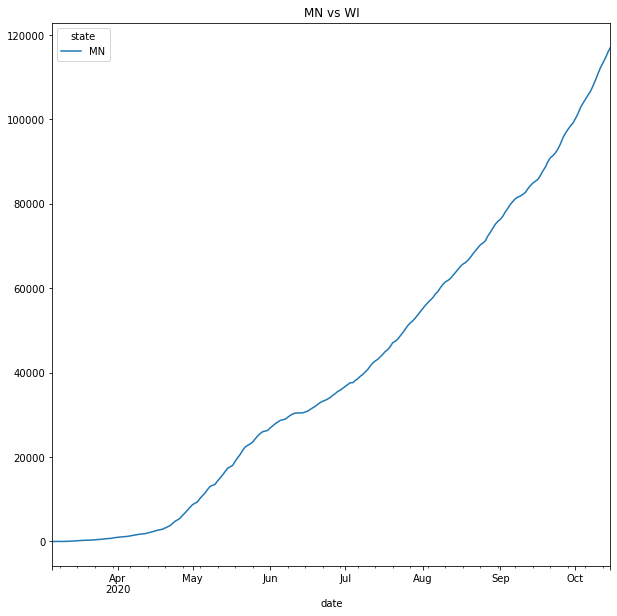

In [21]:
select_viz.positive.unstack(level='state').plot(title='MN vs WI', figsize=(10, 10));

# Data Cleaning
## state_pop_df

In [22]:
# inspecting columns
state_pop_df.columns

Index(['ID State', 'State', 'ID Year', 'Year', 'Population', 'Slug State'], dtype='object')

In [23]:
state_pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID State    52 non-null     object
 1   State       52 non-null     object
 2   ID Year     52 non-null     int64 
 3   Year        52 non-null     object
 4   Population  52 non-null     int64 
 5   Slug State  52 non-null     object
dtypes: int64(2), object(4)
memory usage: 2.6+ KB


In [24]:
# defining fips field from ID state. This new column will be used for merging
state_pop_df['fips'] = state_pop_df['ID State'].str[-2:]

In [25]:
state_df = state_pop_df[['State', 'fips', 'Population']]
state_df.head()

,State,fips,Population
0,Montana,30,1062305
1,Alabama,01,4887871
2,Arizona,04,7171646
3,Arkansas,05,3013825
4,California,06,39557045


# Merging Datasets

In [26]:
covid_df['fips'].unique()

array(['02', '01', '05', '60', '04', '06', '08', '09', '11', '10', '12',
       '13', '66', '15', '19', '16', '17', '18', '20', '21', '22', '25',
       '24', '23', '26', '27', '29', '69', '28', '30', '37', '38', '31',
       '33', '34', '35', '32', '36', '39', '40', '41', '42', '72', '44',
       '45', '46', '47', '48', '49', '51', '78', '50', '53', '55', '54',
       '56'], dtype=object)

In [27]:
covid_wpop = covid_df.merge(state_df, how='inner', on='fips')
covid_wpop.head()

,date,state,positive,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,dataQualityGrade,death,fips,positiveIncrease,deathIncrease,hospitalizedIncrease,State,Population
0,2020-10-15,AK,11348.0,60.0,NaN,NaN,NaN,7.0,NaN,A,65.0,02,165,1,0,Alaska,737438
1,2020-10-14,AK,11183.0,56.0,NaN,NaN,NaN,7.0,NaN,A,64.0,02,144,4,0,Alaska,737438
2,2020-10-13,AK,11039.0,59.0,NaN,NaN,NaN,8.0,NaN,A,60.0,02,155,0,0,Alaska,737438
3,2020-10-12,AK,10884.0,52.0,NaN,NaN,NaN,8.0,NaN,A,60.0,02,198,0,0,Alaska,737438
4,2020-10-11,AK,10686.0,57.0,NaN,NaN,NaN,7.0,NaN,A,60.0,02,258,0,0,Alaska,737438


In [28]:
covid_wpop[covid_wpop.Population == 0]

,date,state,positive,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,dataQualityGrade,death,fips,positiveIncrease,deathIncrease,hospitalizedIncrease,State,Population


In [29]:
covid_wpop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11789 entries, 0 to 11788
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    11789 non-null  datetime64[ns]
 1   state                   11789 non-null  object        
 2   positive                11702 non-null  float64       
 3   hospitalizedCurrently   9594 non-null   float64       
 4   hospitalizedCumulative  7158 non-null   float64       
 5   inIcuCurrently          5491 non-null   float64       
 6   inIcuCumulative         2097 non-null   float64       
 7   onVentilatorCurrently   4621 non-null   float64       
 8   onVentilatorCumulative  730 non-null    float64       
 9   dataQualityGrade        10764 non-null  object        
 10  death                   11086 non-null  float64       
 11  fips                    11789 non-null  object        
 12  positiveIncrease        11789 non-null  int64 

In [30]:
display(covid_wpop['state'].nunique(), covid_df['state'].nunique())

52

56

In [31]:
display(covid_wpop['state'].unique(), covid_df['state'].unique())

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN',
       'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA',
       'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE',
       'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI',
       'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT', 'WA', 'WI', 'WV',
       'WY'], dtype=object)

In [32]:
# checking for omitted states: the result are US territories.
omitted_states = []
for i in covid_df['state'].unique():
    if i not in covid_wpop['state'].unique():
        omitted_states.append(i)
omitted_states

['AS', 'GU', 'MP', 'VI']

### Seven-day rolling average of new cases, by number of days since X average daily cases first recorded

In [33]:
covid_indexed = covid_wpop.set_index(['state']).sort_index().sort_values(['state', 'date'])

In [34]:
covid_indexed.head()

,date,positive,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,dataQualityGrade,death,fips,positiveIncrease,deathIncrease,hospitalizedIncrease,State,Population
state,,,,,,,,,,,,,,,,
AK,2020-03-06,0.0,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,02,0,0,0,Alaska,737438
AK,2020-03-07,0.0,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,02,0,0,0,Alaska,737438
AK,2020-03-08,0.0,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,02,0,0,0,Alaska,737438
AK,2020-03-09,0.0,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,02,0,0,0,Alaska,737438
AK,2020-03-10,0.0,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,02,0,0,0,Alaska,737438


In [35]:
covid_rollavg = covid_indexed[['positive', 'positiveIncrease', 'death', 'deathIncrease']]

In [36]:
covid_rollavg['positiveRollingAvg'] = covid_rollavg.groupby(level=0)['positiveIncrease'].rolling(window=7).mean().values
covid_rollavg

/Users/emiliobello/opt/anaconda3/envs/NewPythonData/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,positive,positiveIncrease,death,deathIncrease,positiveRollingAvg
state,,,,,,
AK,2020-03-06,0.0,0,0.0,0,NaN
AK,2020-03-07,0.0,0,0.0,0,NaN
AK,2020-03-08,0.0,0,0.0,0,NaN
AK,2020-03-09,0.0,0,0.0,0,NaN
AK,2020-03-10,0.0,0,0.0,0,NaN
...,...,...,...,...,...,...
WY,2020-10-11,7611.0,156,54.0,0,158.142857
WY,2020-10-12,7802.0,191,54.0,0,167.571429
WY,2020-10-13,7964.0,162,57.0,3,170.571429


In [37]:
covid_rollavg.head(50)

,date,positive,positiveIncrease,death,deathIncrease,positiveRollingAvg
state,,,,,,
AK,2020-03-06,0.0,0,0.0,0,NaN
AK,2020-03-07,0.0,0,0.0,0,NaN
AK,2020-03-08,0.0,0,0.0,0,NaN
AK,2020-03-09,0.0,0,0.0,0,NaN
AK,2020-03-10,0.0,0,0.0,0,NaN
AK,2020-03-11,0.0,0,0.0,0,NaN
AK,2020-03-12,0.0,0,0.0,0,0.000000
AK,2020-03-13,1.0,1,0.0,0,0.142857
AK,2020-03-14,1.0,0,0.0,0,0.142857


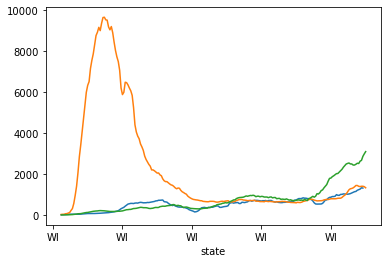

In [38]:
#checking rolling avg calcs
mn_df = covid_rollavg.loc['MN']['positiveRollingAvg']
ny_df = covid_rollavg.loc['NY']['positiveRollingAvg']
wi_df = covid_rollavg.loc['WI']['positiveRollingAvg']
mn_df.plot();
ny_df.plot();
wi_df.plot();

In [40]:
# getting the date value where rolling avg meets the threshold. Now needs looping through each state
# treshold = 10
# index = covid_rollavg[covid_rollavg['positiveRollingAvg'].gt(treshold)].index[0]
# date = index[-1]
# print(date, index)

In [47]:
state_list = covid_rollavg.index.get_level_values('state').unique()
# state_list = ['AK']
threshold = 10
dates = []
for i in state_list:
    new_df = covid_rollavg.loc[i]
    new_df = new_df.loc[new_df['positiveRollingAvg'] >= threshold]
    date = new_df.iloc[0].date
    dates.append(date)
dates

[Timestamp('2020-03-28 00:00:00'),
 Timestamp('2020-03-20 00:00:00'),
 Timestamp('2020-03-20 00:00:00'),
 Timestamp('2020-03-21 00:00:00'),
 Timestamp('2020-03-10 00:00:00'),
 Timestamp('2020-03-13 00:00:00'),
 Timestamp('2020-03-19 00:00:00'),
 Timestamp('2020-03-22 00:00:00'),
 Timestamp('2020-03-24 00:00:00'),
 Timestamp('2020-03-15 00:00:00'),
 Timestamp('2020-03-15 00:00:00'),
 Timestamp('2020-03-25 00:00:00'),
 Timestamp('2020-03-22 00:00:00'),
 Timestamp('2020-03-26 00:00:00'),
 Timestamp('2020-03-16 00:00:00'),
 Timestamp('2020-03-21 00:00:00'),
 Timestamp('2020-03-23 00:00:00'),
 Timestamp('2020-03-22 00:00:00'),
 Timestamp('2020-03-15 00:00:00'),
 Timestamp('2020-03-16 00:00:00'),
 Timestamp('2020-03-18 00:00:00'),
 Timestamp('2020-03-21 00:00:00'),
 Timestamp('2020-03-07 00:00:00'),
 Timestamp('2020-03-14 00:00:00'),
 Timestamp('2020-03-22 00:00:00'),
 Timestamp('2020-03-20 00:00:00'),
 Timestamp('2020-03-27 00:00:00'),
 Timestamp('2020-03-19 00:00:00'),
 Timestamp('2020-03-

In [49]:
info_dict = dict(zip(state_list, dates))
info_dict

{'AK': Timestamp('2020-03-28 00:00:00'),
 'AL': Timestamp('2020-03-20 00:00:00'),
 'AR': Timestamp('2020-03-20 00:00:00'),
 'AZ': Timestamp('2020-03-21 00:00:00'),
 'CA': Timestamp('2020-03-10 00:00:00'),
 'CO': Timestamp('2020-03-13 00:00:00'),
 'CT': Timestamp('2020-03-19 00:00:00'),
 'DC': Timestamp('2020-03-22 00:00:00'),
 'DE': Timestamp('2020-03-24 00:00:00'),
 'FL': Timestamp('2020-03-15 00:00:00'),
 'GA': Timestamp('2020-03-15 00:00:00'),
 'HI': Timestamp('2020-03-25 00:00:00'),
 'IA': Timestamp('2020-03-22 00:00:00'),
 'ID': Timestamp('2020-03-26 00:00:00'),
 'IL': Timestamp('2020-03-16 00:00:00'),
 'IN': Timestamp('2020-03-21 00:00:00'),
 'KS': Timestamp('2020-03-23 00:00:00'),
 'KY': Timestamp('2020-03-22 00:00:00'),
 'LA': Timestamp('2020-03-15 00:00:00'),
 'MA': Timestamp('2020-03-16 00:00:00'),
 'MD': Timestamp('2020-03-18 00:00:00'),
 'ME': Timestamp('2020-03-21 00:00:00'),
 'MI': Timestamp('2020-03-07 00:00:00'),
 'MN': Timestamp('2020-03-14 00:00:00'),
 'MO': Timestamp

In [56]:
# for k, v in info_dict:
#     if covid_rollavg.index = 
covid_rollavg.index.unique()

Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT',
       'WA', 'WI', 'WV', 'WY'],
      dtype='object', name='state')

In [ ]:
# this brings the index
# threshold = 10

# res = list(map(lambda j: j > threshold, covid_rollavg['positiveRollingAvg'])).index(True)
# print(res)

In [ ]:
df = covid_rollavg.loc['AK']['positiveRollingAvg']
df.head(50)

In [ ]:
# this brings the value
# threshold = 10

# res = list(filter(lambda j: j > threshold, covid_rollavg['positiveRollingAvg']))[0]
# print(res)

---

In [ ]:
# reseting the index for loops... is this really necessary?

In [52]:
rollingavg_reset = covid_rollavg.reset_index()
rollingavg_reset.head(25)
rollingavg_reset.dtypes

state                         object
date                  datetime64[ns]
positive                     float64
positiveIncrease               int64
death                        float64
deathIncrease                  int64
positiveRollingAvg           float64
dtype: object

In [ ]:
# note: cumulative number of cases, by number of days since 100th case. It's a way to normalize and compare the states covid 'behavior' after a period of time

## Map Viz DF

In [57]:
# call the latest available date for each state
# latest_date = covid_wpop.date == covid_wpop.date.max() this works, but what if one of the states is not updated to the latest date?
# need an alternative solution to call the last date, TBD in class
latest_date = covid_wpop.date == covid_wpop.date.max()
map_df = covid_wpop[latest_date]
map_df

,date,state,positive,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,dataQualityGrade,death,fips,positiveIncrease,deathIncrease,hospitalizedIncrease,State,Population
0,2020-10-15,AK,11348.0,60.0,NaN,NaN,NaN,7.0,NaN,A,65.0,02,165,1,0,Alaska,737438
224,2020-10-15,AL,169162.0,844.0,18635.0,NaN,1914.0,NaN,1091.0,A,2756.0,01,1185,50,0,Alabama,4887871
447,2020-10-15,AR,96524.0,587.0,6199.0,236.0,NaN,103.0,760.0,A+,1645.0,05,1278,11,51,Arkansas,3013825
671,2020-10-15,AZ,228748.0,726.0,20462.0,173.0,NaN,75.0,NaN,A+,5789.0,04,1113,17,96,Arizona,7171646
897,2020-10-15,CA,858401.0,3078.0,NaN,706.0,NaN,NaN,NaN,B,16757.0,06,3329,118,0,California,39557045
1123,2020-10-15,CO,80777.0,405.0,8068.0,NaN,NaN,NaN,NaN,A,2025.0,08,692,16,65,Colorado,5695564
1348,2020-10-15,CT,62028.0,191.0,12043.0,NaN,NaN,NaN,NaN,B,4540.0,09,167,3,198,Connecticut,3572665
1571,2020-10-15,DC,16166.0,88.0,NaN,22.0,NaN,10.0,NaN,A+,638.0,11,34,0,0,District of Columbia,702455
1796,2020-10-15,DE,22560.0,111.0,NaN,28.0,NaN,NaN,NaN,A+,661.0,10,95,1,0,Delaware,967171
2020,2020-10-15,FL,744988.0,2119.0,47223.0,NaN,NaN,NaN,NaN,A,15932.0,12,3356,144,212,Florida,21299325


In [58]:
map_df.shape

(52, 17)

In [59]:
map_df.columns

Index(['date', 'state', 'positive', 'hospitalizedCurrently',
       'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative',
       'onVentilatorCurrently', 'onVentilatorCumulative', 'dataQualityGrade',
       'death', 'fips', 'positiveIncrease', 'deathIncrease',
       'hospitalizedIncrease', 'State', 'Population'],
      dtype='object')

In [60]:
# reorganizing columns
map_df = map_df[['date', 'State', 'state', 'Population', 
                 'positive', 'positiveIncrease', 'death', 'deathIncrease', 
                 'hospitalizedCurrently', 'hospitalizedIncrease', 'hospitalizedCumulative', 
                 'inIcuCurrently', 'inIcuCumulative', 
                 'onVentilatorCurrently', 'onVentilatorCumulative', 
                 'dataQualityGrade']]
map_df.head()

,date,State,state,Population,positive,positiveIncrease,death,deathIncrease,hospitalizedCurrently,hospitalizedIncrease,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,dataQualityGrade
0,2020-10-15,Alaska,AK,737438,11348.0,165,65.0,1,60.0,0,NaN,NaN,NaN,7.0,NaN,A
224,2020-10-15,Alabama,AL,4887871,169162.0,1185,2756.0,50,844.0,0,18635.0,NaN,1914.0,NaN,1091.0,A
447,2020-10-15,Arkansas,AR,3013825,96524.0,1278,1645.0,11,587.0,51,6199.0,236.0,NaN,103.0,760.0,A+
671,2020-10-15,Arizona,AZ,7171646,228748.0,1113,5789.0,17,726.0,96,20462.0,173.0,NaN,75.0,NaN,A+
897,2020-10-15,California,CA,39557045,858401.0,3329,16757.0,118,3078.0,0,NaN,706.0,NaN,NaN,NaN,B


In [61]:
map_df['positive_per_100K'] = (map_df['positive'] / (map_df['Population'] / 100000)).round(1)
map_df['death_per_100K'] = (map_df['death'] / (map_df['death'] / 100000)).round(1)
map_df.head()

,date,State,state,Population,positive,positiveIncrease,death,deathIncrease,hospitalizedCurrently,hospitalizedIncrease,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,onVentilatorCumulative,dataQualityGrade,positive_per_100K,death_per_100K
0,2020-10-15,Alaska,AK,737438,11348.0,165,65.0,1,60.0,0,NaN,NaN,NaN,7.0,NaN,A,1538.8,100000.0
224,2020-10-15,Alabama,AL,4887871,169162.0,1185,2756.0,50,844.0,0,18635.0,NaN,1914.0,NaN,1091.0,A,3460.9,100000.0
447,2020-10-15,Arkansas,AR,3013825,96524.0,1278,1645.0,11,587.0,51,6199.0,236.0,NaN,103.0,760.0,A+,3202.7,100000.0
671,2020-10-15,Arizona,AZ,7171646,228748.0,1113,5789.0,17,726.0,96,20462.0,173.0,NaN,75.0,NaN,A+,3189.6,100000.0
897,2020-10-15,California,CA,39557045,858401.0,3329,16757.0,118,3078.0,0,NaN,706.0,NaN,NaN,NaN,B,2170.0,100000.0


In [ ]:
# CASES AND DEATH LAST 7 DAYS?

In [ ]:
##### Emilio's Code Ends Here #####

In [ ]:
#### Allan's Code Starts ####

In [ ]:
#### Allan's Code Ends #### 

In [ ]:
#### Matt's Code Starts ####

In [ ]:
#### Matt's Code Ends #### 